# Feature Engineering
## Import Libraries

In [1]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from scipy.stats import chi2_contingency
from scipy.stats import pointbiserialr

## Import Cleaned Dataset

In [6]:
df = pd.read_csv('Data/cleaned.csv')

In [8]:
df.columns

Index(['Booking_ID', 'no_of_adults', 'no_of_children', 'no_of_weekend_nights',
       'no_of_week_nights', 'type_of_meal_plan', 'required_car_parking_space',
       'room_type_reserved', 'lead_time', 'arrival_year', 'arrival_month',
       'arrival_date', 'market_segment_type', 'repeated_guest',
       'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled',
       'avg_price_per_room', 'no_of_special_requests', 'booking_status',
       'arrival_week', 'arrival_dayofweek', 'arrival_quarter',
       'arrival_dayofyear', 'arrival_isweekend', 'booking_date',
       'booking_year', 'booking_month', 'booking_week', 'booking_dayofweek',
       'booking_quarter', 'booking_dayofyear', 'booking_isweekend'],
      dtype='object')

In [22]:
df['booking_status'] = df['booking_status'].apply(lambda x: 1 if x=='canceled' else 0)

## Feature Engineering on Number of Customers

There are several ways to capture the relationship between no_of_adults and no_of_children:
1. sum of the 2 variables to represent the total number of customers
2. whether the customer is a solo traveller (only one adult or one children)
3. customer type with the following categories (adults only, children only and mix of adults and children)

We will create features with all the possible methods and visualize the resulted variables.

In [49]:
# this function will be used to create customers number related features
def process_customer_number(df):
    df["no_of_customers"] = df['no_of_adults'] + df['no_of_children']
    df["solo_traveller"] = ((df["no_of_adults"]==1) & (df["no_of_children"]==0)) | ((df["no_of_adults"]==0) & (df["no_of_children"]==1))
    
    def get_traveller_type(x):
        if (x["no_of_adults"]>0) & (x["no_of_children"]==0):
            return 'adults_only'
        elif (x["no_of_adults"]==0) & (x["no_of_children"]>0):
            return 'children_only'
        else:
            return 'mixed'
    df["traveller_type"] = df.apply(get_traveller_type, axis=1)

In [50]:
process_customer_number(df)

In [52]:
customer_number_cols = ["no_of_customers", "solo_traveller", "traveller_type"]

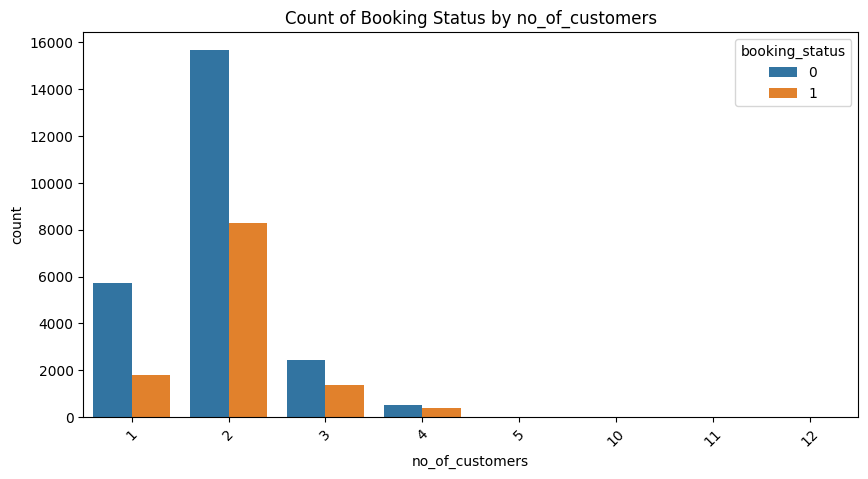

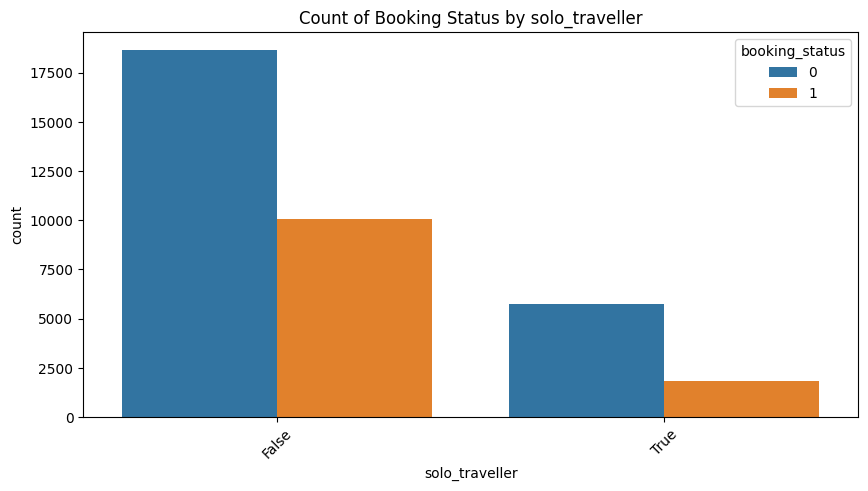

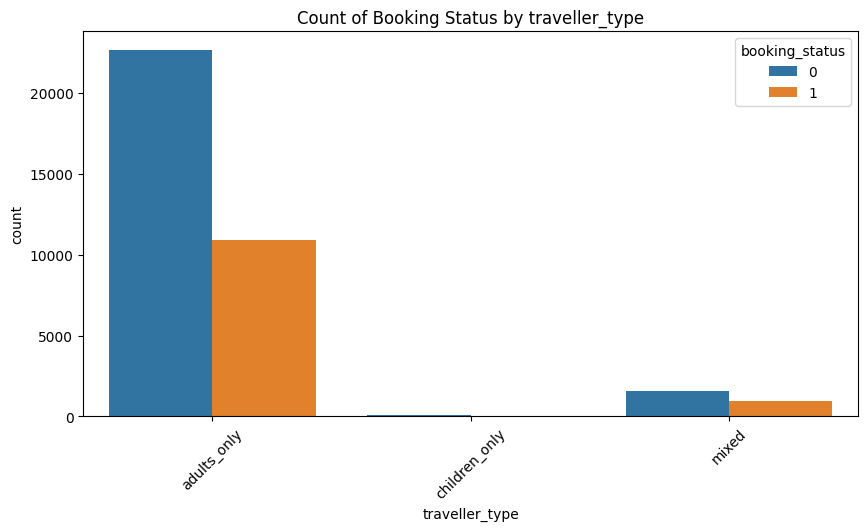

In [53]:
for col in customer_number_cols:
    plt.figure(figsize=(10, 5))
    sns.countplot(x=col, hue='booking_status', data=df)
    plt.title(f'Count of Booking Status by {col}')
    plt.xticks(rotation=45)
    plt.show()

From the graphs, some patterns can be visualized:
1. solo traveller has a lower cancellation rate, which is likely to be because they have more control over their schedule and are less likely to have schedule conflict
2. most of the traveller groups consist of only adults, and they tend to have a lower cancellation rate compared to when mixing with children

## Feature Engineering on Number of Nights

There are several ways to capture the relationship between no_of_weekend_nights and no_of_week_nights:
1. sum of the 2 variables to represent the total number of nights stayed
2. customer type with the following categories (hour room, weekend only, weekday only and mix of both)

We will create features with all the possible methods and visualize the resulted variables.

In [61]:
# this function will be used to create nights number related features
def process_nights_number(df):
    df["no_of_nights"] = df['no_of_weekend_nights'] + df['no_of_week_nights']
    
    def get_stay_type(x):
        if (x["no_of_weekend_nights"]==0) & (x["no_of_week_nights"]==0):
            return 'hour_room'
        elif (x["no_of_weekend_nights"]>0) & (x["no_of_week_nights"]==0):
            return 'weekend_only'
        elif (x["no_of_weekend_nights"]==0) & (x["no_of_week_nights"]>0):
            return 'weekday_only'
        else:
            return 'mixed'
    df["stay_type"] = df.apply(get_stay_type, axis=1)

In [64]:
process_nights_number(df)

In [62]:
nights_number_cols = ["no_of_nights", "stay_type"]

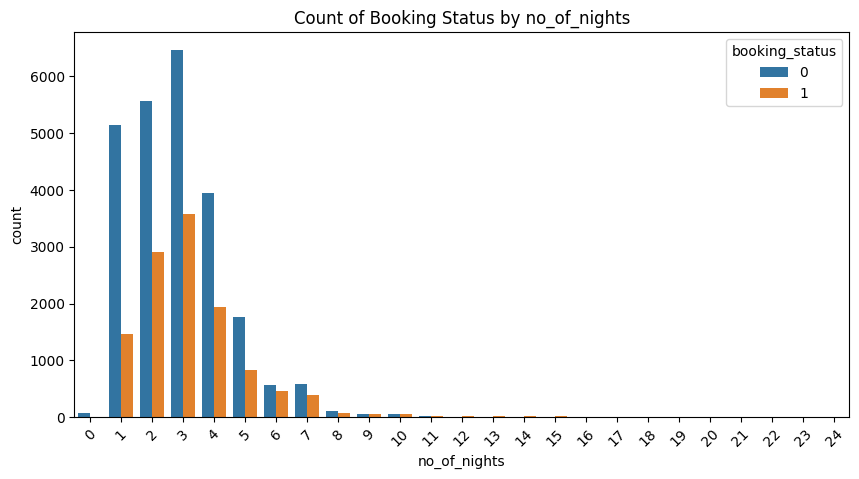

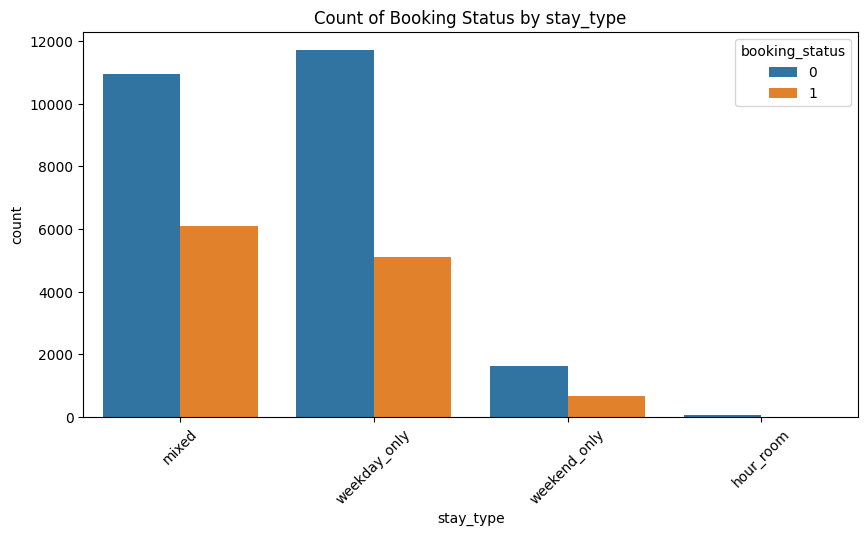

In [65]:
for col in nights_number_cols:
    plt.figure(figsize=(10, 5))
    sns.countplot(x=col, hue='booking_status', data=df)
    plt.title(f'Count of Booking Status by {col}')
    plt.xticks(rotation=45)
    plt.show()

From the graphs, some patterns can be visualized:
1. the cancellation rates seem to grow as the total number of nights stayed increases, especially when it is greater than 5 nights
2. weekday only stay type has a relatively low cancellation rate, which is likely to be because for this kind of trip, customers are likely to prepare ahead, such as applying for leave, and refrain from changing

## Feature Engineering on Previous Bookings

There are several ways to capture the relationship between no_of_previous_cancellations and no_of_previous_bookings_not_canceled:
1. sum of the 2 variables to represent the total number of previous bookings
2. cancellation rate based on previous bookings (number of cancelled/number of previous bookings)
3. cancellation type with the following categories (no previous booking, never cancelled before, all previous bookings are cancelled, mix of cancelled and successful stay)

We will create features with all the possible methods and visualize the resulted variables.

In [78]:
# this function will be used to create previous bookings related features
def process_previous_booking(df):
    df["no_of_previous_bookings"] = df['no_of_previous_cancellations'] + df['no_of_previous_bookings_not_canceled']
    df["no_of_previous_cancellation_rate"] = df.apply(lambda x: 0 if x["no_of_previous_bookings"]==0 else x['no_of_previous_cancellations']/x["no_of_previous_bookings"], axis=1)
    
    def get_cancellation_type(x):
        if (x["no_of_previous_cancellations"]==0) & (x["no_of_previous_bookings_not_canceled"]==0):
            return 'no_booking'
        elif (x["no_of_previous_cancellations"]>0) & (x["no_of_previous_bookings_not_canceled"]==0):
            return 'all_cancelled'
        elif (x["no_of_previous_cancellations"]==0) & (x["no_of_previous_bookings_not_canceled"]>0):
            return 'all_successful'
        else:
            return 'mixed'
    df["cancellation_type"] = df.apply(get_cancellation_type, axis=1)

In [79]:
process_previous_booking(df)

In [70]:
previous_booking_cols = ["no_of_previous_bookings", "no_of_previous_cancellation_rate", "cancellation_type"]

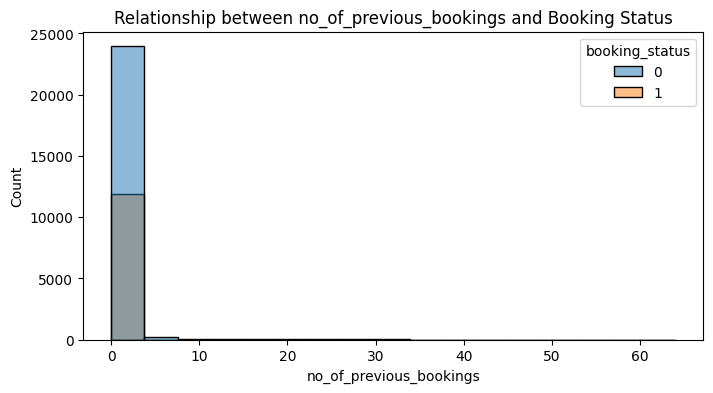

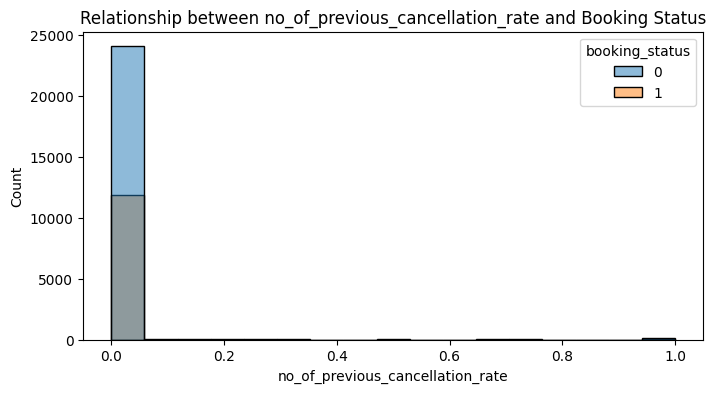

In [83]:
for col in previous_booking_cols[:2]:
    plt.figure(figsize=(8, 4))
    sns.histplot(x=col, hue='booking_status', data=df)
    plt.title(f'Relationship between {col} and Booking Status')
    plt.show()

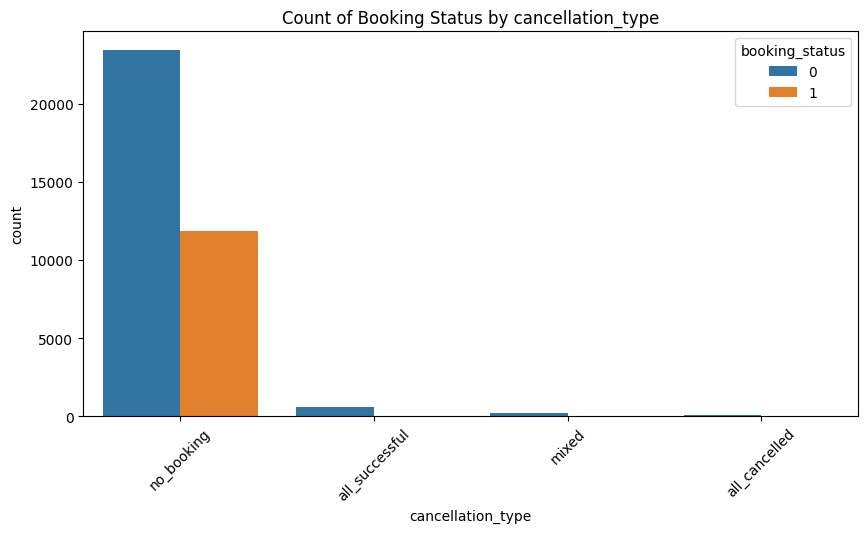

In [85]:
for col in previous_booking_cols[2:]:
    plt.figure(figsize=(10, 5))
    sns.countplot(x=col, hue='booking_status', data=df)
    plt.title(f'Count of Booking Status by {col}')
    plt.xticks(rotation=45)
    plt.show()

From the graphs, some patterns can be visualized:
1. when customers have previous bookings with the hotel, no matter cancelled or not, the customers are likely to have a lower cancellation rate, however, most customers do not have bookings before, which can be verified by the repeated_guest column

## Feature Engineering on Price

These features may be related to avg_price_per_room: avg_price_per_room, type_of_meal_plan, room_type_reserved, market_segment_type, and their relationships are visualized below.

In [104]:
df[df['avg_price_per_room']==0]

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,...,solo_traveller,adults_only,traveller_type,no_of_nights,saty_type,stay_type,ratio_of_nights,no_of_previous_bookings,no_of_previous_cancellation_rate,cancellation_type
63,inn00064,1,0,0,1,meal plan 1,0,room_type 1,2,2017,...,True,True,adults_only,1,weekday_only,weekday_only,0.0,0,0.000000,no_booking
145,inn00146,1,0,0,2,meal plan 1,0,room_type 1,13,2018,...,True,True,adults_only,2,weekday_only,weekday_only,0.0,8,0.375000,mixed
209,inn00210,1,0,0,0,meal plan 1,0,room_type 1,4,2018,...,True,True,adults_only,0,hour_room,hour_room,NaN,0,0.000000,no_booking
266,inn00267,1,0,0,2,meal plan 1,0,room_type 1,1,2017,...,True,True,adults_only,2,weekday_only,weekday_only,0.0,1,0.000000,all_successful
267,inn00268,1,0,2,1,meal plan 1,0,room_type 1,4,2017,...,True,True,adults_only,3,mixed,mixed,2.0,0,0.000000,no_booking
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35946,inn35984,1,0,0,1,meal plan 1,0,room_type 7,0,2018,...,True,True,adults_only,1,weekday_only,weekday_only,0.0,21,0.190476,mixed
36043,inn36081,1,0,1,1,meal plan 1,0,room_type 7,0,2018,...,True,True,adults_only,2,mixed,mixed,1.0,18,0.166667,mixed
36077,inn36115,1,0,0,1,meal plan 1,0,room_type 1,1,2018,...,True,True,adults_only,1,weekday_only,weekday_only,0.0,0,0.000000,no_booking
36180,inn36218,2,0,2,1,meal plan 1,0,room_type 2,3,2017,...,False,True,adults_only,3,mixed,mixed,2.0,0,0.000000,no_booking


Why are there bookings with avg_price_per_room=0?

As including observations with avg_price_per_room=0 will greatly impact the average room price of different groups, we will exclude these observations from the following visualization.

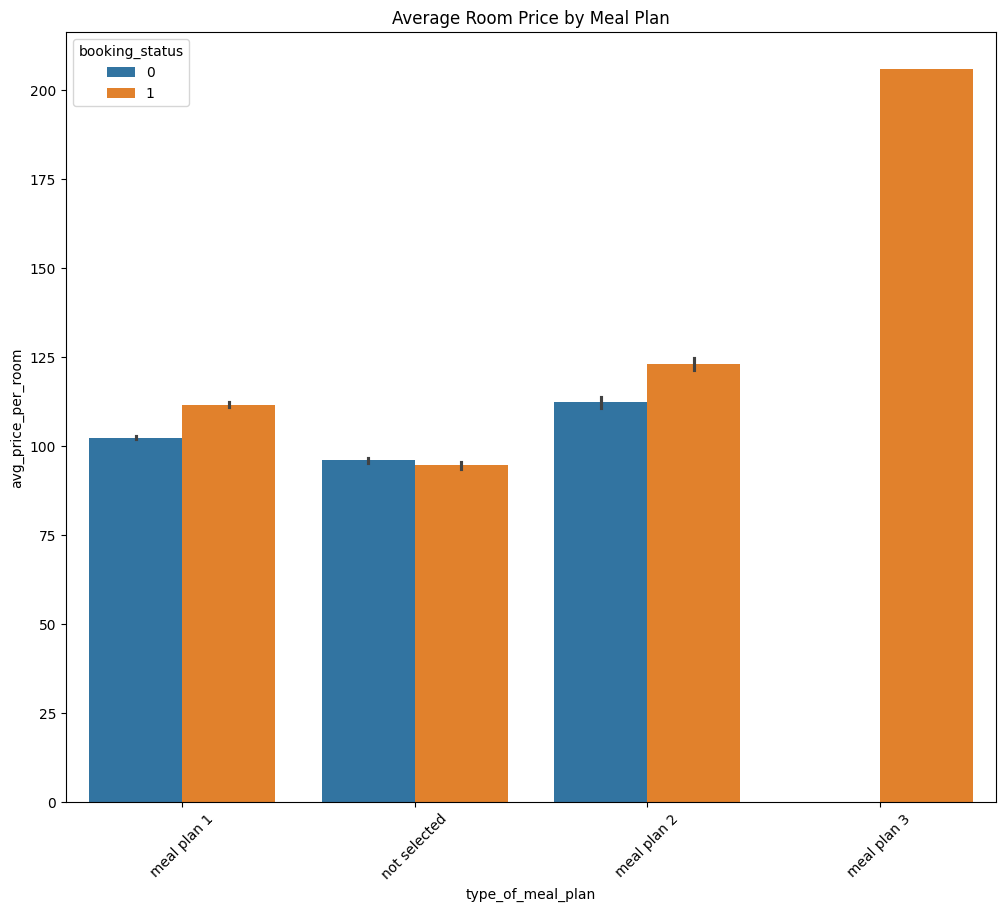

In [105]:
plt.figure(figsize=(12,10))
sns.barplot(x='type_of_meal_plan', y='avg_price_per_room', hue='booking_status', data=df[df['avg_price_per_room']!=0])
plt.title(f'Average Room Price by Meal Plan')
plt.xticks(rotation=45)
plt.show()

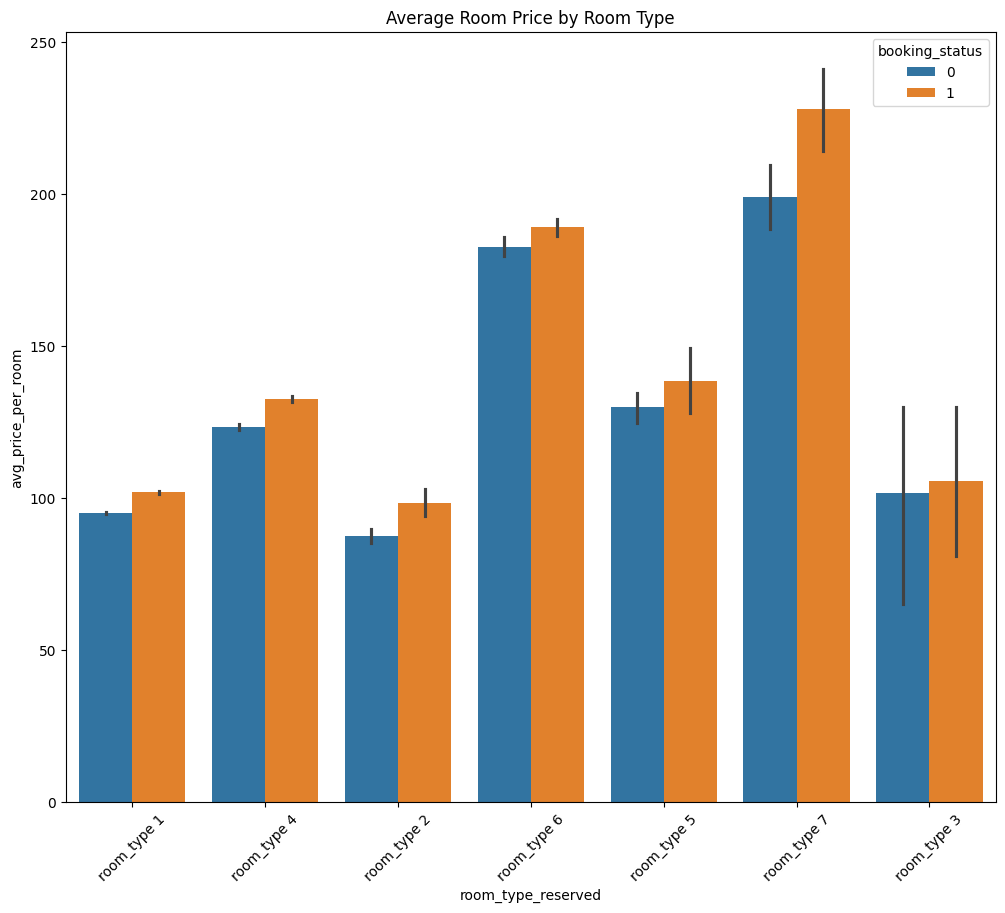

In [106]:
plt.figure(figsize=(12,10))
sns.barplot(x='room_type_reserved', y='avg_price_per_room', hue='booking_status', data=df[df['avg_price_per_room']!=0])
plt.title(f'Average Room Price by Room Type')
plt.xticks(rotation=45)
plt.show()

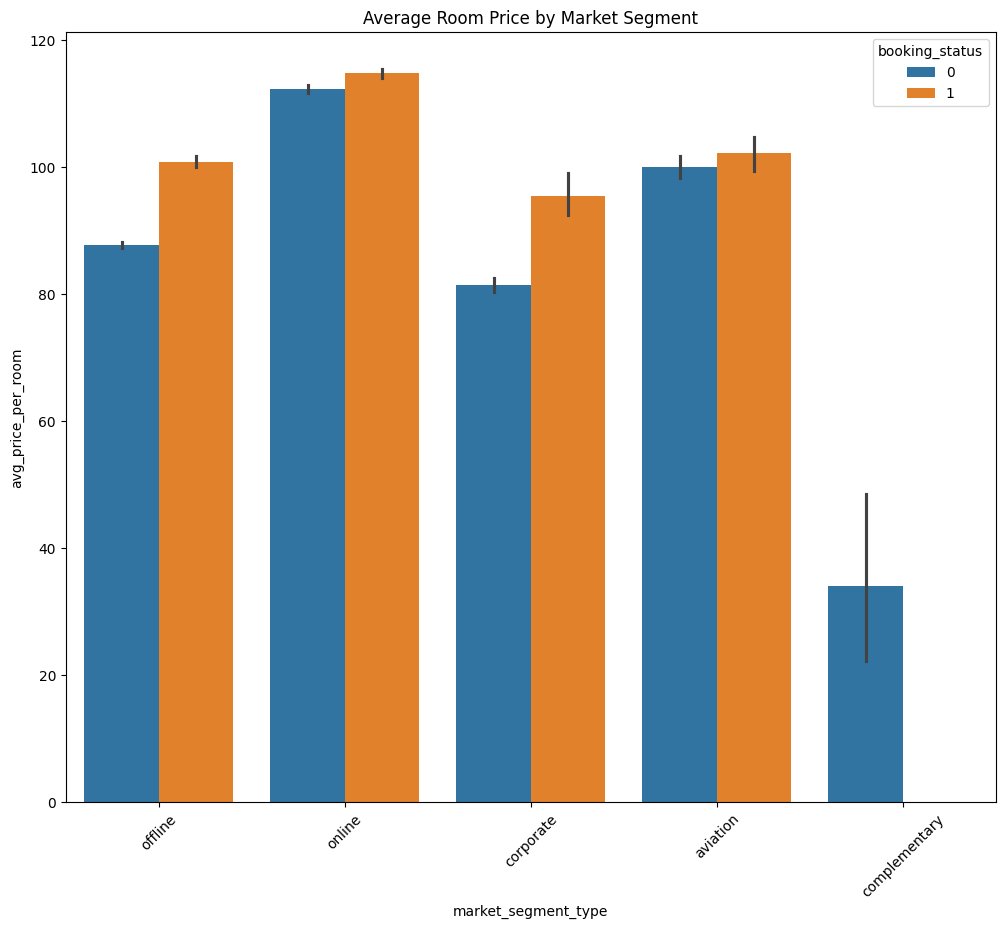

In [107]:
plt.figure(figsize=(12,10))
sns.barplot(x='market_segment_type', y='avg_price_per_room', hue='booking_status', data=df[df['avg_price_per_room']!=0])
plt.title(f'Average Room Price by Market Segment')
plt.xticks(rotation=45)
plt.show()

Despite that different categories in meal plan and room type have more similar price with intra-group observations compared with inter-group ones, no significant difference can be observed between cancelled and non-cancelled groups, which suggests that these features may not be useful for predicting cancellations.

## Feature Engineering on Dates

In [3]:
# this function will be used to create arrival date related features
def process_arrival_date(df):
    temp = df.rename(columns={
        'arrival_year': 'year',
        'arrival_month': 'month',
        'arrival_date': 'day'
    })

    df['date'] = pd.to_datetime(temp[['year', 'month', 'day']], errors='coerce')
    df['arrival_week'] = df['date'].dt.isocalendar().week.astype(float)
    df['arrival_dayofweek'] = df['date'].dt.dayofweek
    df['arrival_quarter'] = df['date'].dt.quarter
    df['arrival_dayofyear'] = df['date'].dt.dayofyear
    df['arrival_isweekend'] = df['arrival_dayofweek'].apply(lambda x:1 if x>=5 else 0)
    
    df.drop(columns='date', inplace=True)

In [4]:
# this function will be used to create booking date related features
def process_booking_date(df):
    temp = df.rename(columns={
        'arrival_year': 'year',
        'arrival_month': 'month',
        'arrival_date': 'day'
    })

    df['booking_date'] = pd.to_datetime(temp[['year', 'month', 'day']], errors='coerce')
    df['booking_date'] = df['booking_date'] - pd.Series(
        [pd.Timedelta(i, 'd') for i in df.lead_time],
        index=df.index
    )
    
    df['booking_year'] = df['booking_date'].dt.year
    df['booking_month'] = df['booking_date'].dt.month
    df['booking_week'] = df['booking_date'].dt.isocalendar().week.astype(float)
    df['booking_dayofweek'] = df['booking_date'].dt.dayofweek
    df['booking_quarter'] = df['booking_date'].dt.quarter
    df['booking_dayofyear'] = df['booking_date'].dt.dayofyear
    df['booking_date'] = df['booking_date'].dt.day
    df['booking_isweekend'] = df['arrival_dayofweek'].apply(lambda x:1 if x>=5 else 0)

In [7]:
# call the helper functions
process_arrival_date(df)
process_booking_date(df)

In [113]:
# this function will be used to plot the number of cancelled bookings
def plot_dots_ordinal(feature, ax):
    dots = df.groupby(feature)['booking_status'].sum().reset_index()
    dots.sort_values(feature, inplace=True)
    train_containers = ax.containers[0]
    
    containers = [train_containers]
    
    for container in containers:
        x_s = [bar.get_x() + bar.get_width()/2 for bar in container]
        y_s = dots.booking_status
        x_s = x_s[:y_s.shape[0]]
        ax.plot(x_s, y_s, marker='.', alpha=0.8, markersize=10)

Barplots are used to show the total number of booking, and lines show the number of canceled bookings.

In [111]:
arrival_columns = ['arrival_year', 'arrival_quarter', 'arrival_month', 'arrival_dayofweek', 
           'arrival_date', 'arrival_week', 'arrival_dayofyear', 'arrival_isweekend']
n_cols = 3
n_rows = math.ceil(len(arrival_columns)/n_cols)

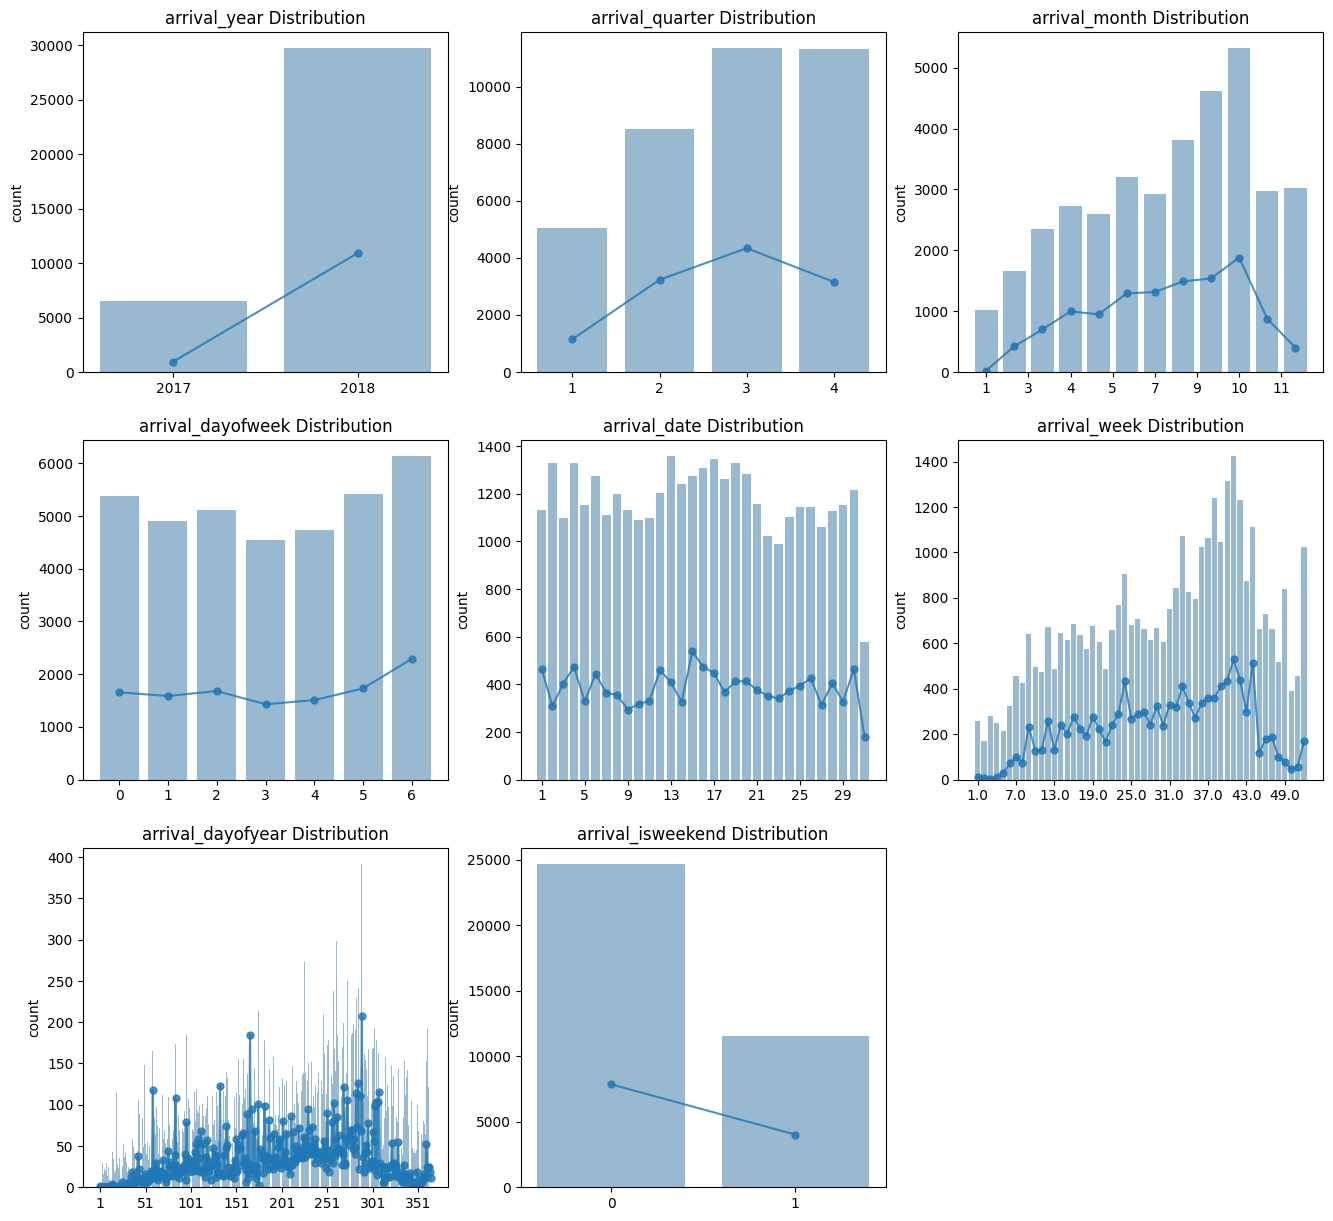

In [114]:
# visualize arrival date related features
fig, ax = plt.subplots(n_rows, n_cols, figsize=(16, n_rows*5))
ax = ax.flatten()

for i, column in enumerate(arrival_columns):
    column = arrival_columns[i]
    plot_axes = [ax[i]]
    sns.countplot(data=df, x=column, ax=ax[i], alpha=0.5)
    plot_dots_ordinal(column, ax[i])
    
    # titles
    ax[i].set_title(f'{column} Distribution')
    ax[i].set_xlabel(None)
    
    # axis
    if len(ax[i].get_xticklabels()) > 10:
        ax[i].xaxis.set_major_locator(MaxNLocator(10))
    
for i in range(i+1, len(ax)):
    ax[i].axis('off')
    

In [115]:
booking_columns = ['booking_year', 'booking_quarter', 'booking_month', 'booking_dayofweek', 
           'booking_date', 'booking_week', 'booking_dayofyear', 'booking_isweekend']
n_cols = 3
n_rows = math.ceil(len(booking_columns)/n_cols)

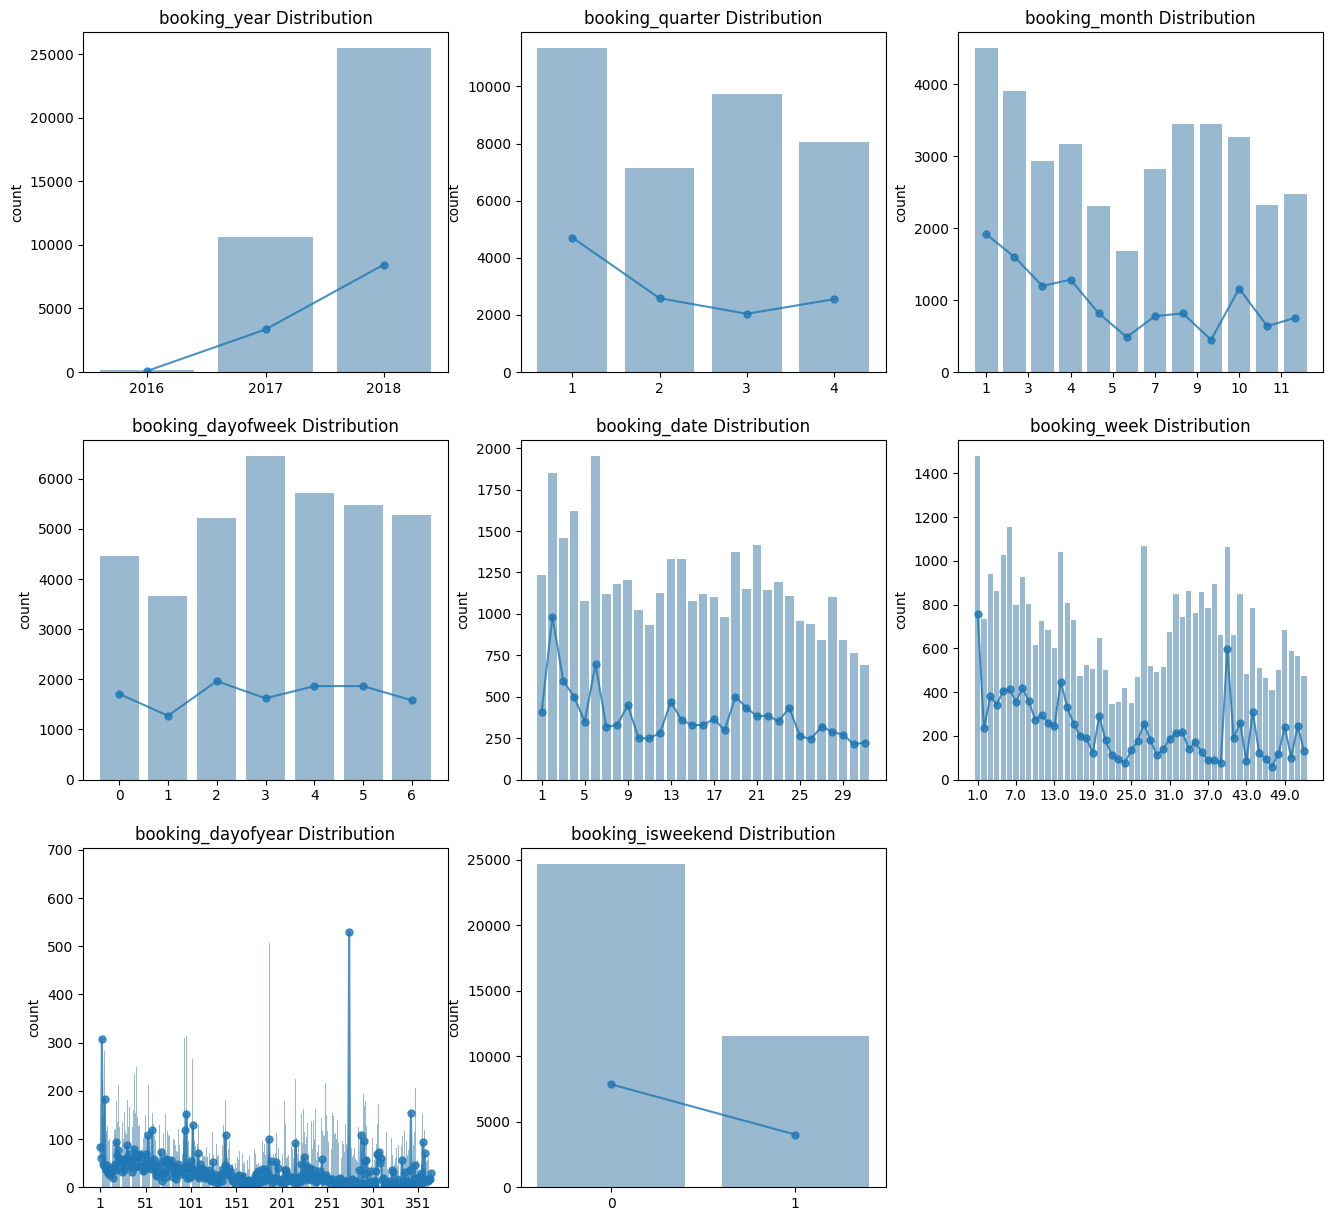

In [116]:
# visualize booking date related features
fig, ax = plt.subplots(n_rows, n_cols, figsize=(16, n_rows*5))
ax = ax.flatten()

for i, column in enumerate(booking_columns):
    column = booking_columns[i]
    plot_axes = [ax[i]]
    sns.countplot(data=df, x=column, ax=ax[i], alpha=0.5)
    plot_dots_ordinal(column, ax[i])
    
    # titles
    ax[i].set_title(f'{column} Distribution')
    ax[i].set_xlabel(None)
    
    # axis
    if len(ax[i].get_xticklabels()) > 10:
        ax[i].xaxis.set_major_locator(MaxNLocator(10))
    
for i in range(i+1, len(ax)):
    ax[i].axis('off')

With the help of visualization, we can use the derived date columns in the following ways:
1. Arrival or booking year should not be used as features, because the newly injected data are likely to be in later years and we do not have long enough timeframe to capture the trend over years
2. Arrival or booking quarter/month could be useful features to keep, as they capture the seasonality within a year, as these 2 features are highly correlated, only one of them need to be kept, and encoded
3. Arrival or booking day of week can be encoded directly, or used to derive feature: whether arrival/booking on weekend
4. Arrival or booking date, week, and day of year may not be useful to keep, because of their high cardinality and insufficient number of observations under each category, which may lead to overfitting